 # <strong> Introduction to artificial neural networks </strong>
 Spring 2023 - Toulouse INP/ENSEEIHT<br /> 
 by Ruming PAN & Mohamed SAADI<br /> 
 Last update: 20-01-2023<br /> 
 
 This notebook contains three parts:<br />
 <ol>
  <li><strong>Part 1: Building a neural network</strong>, in which a function ```ANN``` builds a DNN (dense neural network) knowing the number of layers (hidden + output), the number of neurons per layer, and given the parameters (weights and biases) for each layer. You are asked to implement an additional activation function (e.g., linear, ReLU) following the example given for the logistic function and test them in new ANN.</li>
  <li><strong>Part 2: Training a neural network</strong>, where a set of data "abalone_data.xlsx" is given to train a DNN by back-propagating the gradient of a loss function with respect to the network parameters. You are required to do three things: (1) define the training and test datasets, (2) scale the features, and most importantly (3) complete the function ```ANN_backpro``` to successfully run the algorithm. </li>
  <li><strong>Part 3: Make your life easier with Keras</strong>, where you are asked to implement a similar DNN using ```keras```, which is a high-level interface for ```TensorFlow```, a famous framework for deep machine learning. The objective here is to present one of the most used libraries in python-based machine learning eco-system. As you will notice, the implementation is very friendly and easy.</li>
</ol> 
 

## <strong>Part 1: Building a neural network</strong>
 In this part, you are required to understand the structure of a neural network and build one given a number of layer ```NL``` and a list of number of neurons per layer ```NpL```.

### Step 1: Import libraries, define global functions and hyperparameters

<strong>Task 1:</strong> Based on the example provided for the logistic function, build new activation functions (tanh, ReLU, and linear) in order to use them later for the neural network.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import tensorflow as tf
from tensorflow import keras

## a function that takes a dataframe and returns some basic stastics of its columns
def datasum(df):
    dfmin = df.apply(np.min, 0)
    dfmedian = df.apply(np.median, 0)
    dfmean = df.apply(np.mean,0)
    dfmax = df.apply(np.max, 0)
    dfstd = df.apply(np.std, 0)
    dfsummary = pd.DataFrame(np.array([dfmean, dfstd, dfmin, dfmedian, dfmax]), columns=list(df.columns[:]))
    dfsummary["Statistic"] = ["mean", "std", "min", "median", "max"]
    xcol = dfsummary.shape[1]
    colarr = [dfsummary.columns[xcol-1]]
    for item in dfsummary.columns[0:(xcol-1)]:
        colarr.append(item)
    dfto = dfsummary[colarr]
    return dfto

## activation functions and their derivatives
def logistic(x, mode = "n"):
    '''
    mode = "n" : returns f(x)
    mode = "d": returns f'(x)
    '''
    t = np.exp(-x)
    if mode == "n":
        fx = 1/(1+t)
    if mode == "d":
        fx = t/(1+t)**2
    return fx

## define new functions here

def tanh(x, mode = "n"):
    '''
    mode = "n" : returns f(x)
    mode = "d": returns f'(x)
    '''
    p = np.exp(x)
    n = np.exp(-x)
    if mode == "n":
        fx = p-n/(p+n)
    if mode == "d":
        fx = 1- (p-n/(p+n))**2
    return fx

def relu(x, mode = "n"):
    '''
    mode = "n" : returns f(x)
    mode = "d": returns f'(x)
    '''
    if mode == "n":
        fx = np.where(x < 0, 0, x)
    if mode == "d":
        fx = np.where(x < 0, 0, x)
        fx = np.where(x >= 0, 1, x)
    return fx

def Linear(x, mode = "n"):
    '''
    mode = "n" : returns f(x)
    mode = "d": returns f'(x)
    '''
    if mode == "n":
        fx = x
    if mode == "d":
        fx = 1
    return fx

#### Hyperparameters: number of layers, size of each layer, and activation function per layer
<strong>Indication:</strong> The hyperparameters ```NL```, ```NpL``` and ```Nfx``` are very important throughout the code. They define the number of layers, the number of neurons per each layer, and the number of input features. Always make sure that the size of ```NpL``` and ```ActivFun``` is equal to ```NL```.

In [2]:
## NL is the number of layers including the hidden layers AND the output layer
NL = 2
## NpL defines the number of neurones per each layer. The length of NpL should be exactly equal to NL
NpL = [3, 1]
## ActivFun defines the activation functions per each layer
ActivFun = ['logistic', 'logistic']

## Add the number of features x
Nfx = 2
## List of size of layers -1: important for automatic definition of parameters
NpLm1 = [Nfx]
for iL in np.arange(len(NpL)-1):
    NpLm1.append(NpL[iL])
print("Number of neurons per layer: ", NpL)
print("Number of neurons from the previous layer: ", NpLm1)

Number of neurons per layer:  [3, 1]
Number of neurons from the previous layer:  [2, 3]


#### Initialization of parameters
<strong>Task 2:</strong> Initialize the parameters (weights and biases) using the function ```np.random.rand``` (https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html). Convenient initial parameter values should be between -1 and 1.

In [3]:
## List of weights and biases
Wts = []
bias = []
for iL in np.arange(len(NpL)):
    ## random initialization
    ## the initial parameters should be between -1 and 1
    ## use the function np.random.rand to make random initializations (but these will be between 0 and 1)
    WL = (np.random.rand(NpL[iL], NpLm1[iL])-0.5)*2
    bL = (np.random.rand(NpL[iL])-0.5)*2
    ## appending
    Wts.append(WL)
    bias.append(bL)
print(Wts[0].shape)
print(bias[0].shape)

(3, 2)
(3,)


### Step 2: Construct the neural network

<strong>Task 3:</strong> Complete this function with the equations for each layer to compute the vectors $z_{L}$ and their activation $y_{L} = \sigma(z_{L})$. The function should return a list ```z``` and a list ```y``` that have ```NpL``` arrays each.

In [4]:
def ANN(x, NpL, Nfx, Wts, bias, ActivFun):
    '''
    This function computes the output of a neural network containing NL layers
    where NL is the length of NpL. 
    o NpL contains the number of neurons per each hidden layer + the output layer. 
    o Nfx is the number of input features.
    o Wts is a list that contains the 2D arrays of weights for each layer.
    Each 2D array of weights has dimensions nL x nL-1, nL being the number of neurons
    of current layer L, and nL-1 the number of neurons (or features) of layer L-1.
    o bias is a list of 1D arrays of weights for each layer.
    Each 1D array has dimensions nL x 1. When there are many data points (or members), say
    n data points, the bias should be repeated using the function np.tile.
    o ActivFun contains the name of the activation function for each layer.
    '''
    print('x shape:', x.shape)
    print('NpL:', NpL)
    print('Nfx:', Nfx)
    print('Wts:', len(Wts))

    n = x.shape[1]
    yLm1 = x

    print('n vaut:', n)
    print('NL vaut:', len(NpL))
    
    ## z is a list that saves the zL arrays for each hidden and output layer
    z = []
    ## similarly, y is a list that saves the yL arrays. Specifically, yL[NL-1] contains the output.
    y = []
    for iL in np.arange(len(NpL)):
        ## parameters
        WL = Wts[iL]
        bL = bias[iL]
        ## multiplication
        ## make sure that the operation is correct for n individual points.
        ## the dimension of zL should be nL x n. Since bL is nL x 1, use np.tile to overcome this issue.
        print('WL shape:', WL.shape)
        print('yLm1 shape:', yLm1.shape)
        print('bL shape:', bL.shape)
        
        zL = np.dot(WL, yLm1) + np.tile(bL,(n,1)).T
        z.append(zL)

        print('zL shape:', zL.shape)
        print('bL shape:', bL.shape)
        print("n",n)

        ## activation
        ## to call a function given its name, use the function fx = globals()["fun_name"]
        sigma = globals()[ActivFun[iL]]
        yL = sigma(zL)
        y.append(yL)
        ## move to next layer
        yLm1 = yL
    return y,z

### Step 3: Verify that the ANN works for a simple example

In [5]:
## Input: 4 data points x 2 features (Nfx = 2)
input_features = np.array([[0,0], 
                           [0,1], 
                           [1,0], 
                           [1,1]])
print(input_features.shape)
print(input_features)

(4, 2)
[[0 0]
 [0 1]
 [1 0]
 [1 1]]


In [6]:
# Output: 4 data points x 1 feature
target_output = np.array([[0], [1], [1], [1]])
print(target_output.shape)
print(target_output)

(4, 1)
[[0]
 [1]
 [1]
 [1]]


#### Generate outputs for the 4 individuals
Run this cell to test your neural network. It should deliver an output ysim of shape (n,1), where n is the number of data points (NOT features).

In [7]:
## This where you can test your neural network
x_in = input_features.T
y,z = ANN(x = x_in, NpL = NpL, Nfx = Nfx, Wts = Wts, bias = bias, ActivFun = ActivFun)
ysim = y[NL-1].T
print(ysim.shape)

x shape: (2, 4)
NpL: [3, 1]
Nfx: 2
Wts: 2
n vaut: 4
NL vaut: 2
WL shape: (3, 2)
yLm1 shape: (2, 4)
bL shape: (3,)
zL shape: (3, 4)
bL shape: (3,)
n 4
WL shape: (1, 3)
yLm1 shape: (3, 4)
bL shape: (1,)
zL shape: (1, 4)
bL shape: (1,)
n 4
(4, 1)


#### Goodness of fit: MSE and RMSE
<strong>Task 4:</strong> Complete the equation of MSE and RMSE to estimate the errors of the simulation output of the neural network. Use the matrix product to compute the MSE.

In [8]:
n = target_output.shape[0]
MSE = np.dot((target_output - ysim).T,(target_output - ysim))/n
print("MSE = ", MSE)

RMSE = np.sqrt(MSE)
print("RMSE = ", RMSE)

MSE =  [[0.34564041]]
RMSE =  [[0.5879119]]


## <strong>Part 2: Training a neural network</strong>
 In this part, a backpropagation algorithm is implemented to train the neural network.

### Step 1: Read the data, define the training and the test datasets

#### Reading the dataset
Any machine learning task involves preparing/preprocessing the data to make it ready for digestion by the machine learning algorithm.

At this stage, the data has a 2D shape (lines = individuals or data points, columns = features). The dimensions of the shape of the data help you define the structure of your neural network.

The "abalone_data.xlsx" dataset that are used for this exercise can be downloaded from https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/. They contain measurements of the following properties of 4177 members of marine snails (<em>haliotis</em>):
<ol>
  <li><em>Type</em>: male (1), immature (0), female (-1); </li>
  <li><em>LongestShell_mm</em>: longest shell measurement in mm; </li>
  <li><em>Diameter_mm</em>: length perpendicular to LongestShell in mm;</li>
  <li><em>Height_mm</em>: height of the member with meat in shell in mm;</li>
  <li><em>WholeWeight_g</em>: mass of the whole abalone in g;</li>
  <li><em>ShuckedWeight_g</em>: weight of meat in the abalone in g;</li>  
  <li><em>VisceraWeight_g</em>: gut weight of the abalone (after bleeding) in g;</li>
  <li><em>ShellWeight_g</em>: weight of the abalone after being dried in g;</li>
  <li><em>Age_yr</em>: age of the abalone in years.</li>
</ol> 
 
The objective of the exercise is to succeed at predicting the age of the abalone knowing its gender, form, and weight.

<strong>Task 5:</strong> Complete the first instruction ```pd.read_excel``` to read the dataset.

In [9]:
df = pd.read_excel("abalone_data.xlsx", sheet_name="Sheet1")
display(df.head(5).style.format("{0:.2f}").set_caption("Few lines of the dataset :"))
dfsum = datasum(df)
pd.options.display.float_format = '{:,.2f}'.format
display(dfsum.style.hide(axis = "index").set_caption("Statistics of the dataset"))

,Type,LongestShell_mm,Diameter_mm,Height_mm,WholeWeight_g,ShuckedWeight_g,VisceraWeight_g,ShellWeight_g,Age_yr
0,1.00,0.46,0.36,0.10,0.51,0.22,0.10,0.15,15.00
1,1.00,0.35,0.27,0.09,0.23,0.10,0.05,0.07,7.00
2,-1.00,0.53,0.42,0.14,0.68,0.26,0.14,0.21,9.00
3,1.00,0.44,0.36,0.12,0.52,0.22,0.11,0.15,10.00
4,0.00,0.33,0.26,0.08,0.20,0.09,0.04,0.06,7.00


Statistic,Type,LongestShell_mm,Diameter_mm,Height_mm,WholeWeight_g,ShuckedWeight_g,VisceraWeight_g,ShellWeight_g,Age_yr
mean,0.052909,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.822142,0.120079,0.099228,0.041822,0.490330,0.221936,0.109601,0.139186,3.223783
min,-1.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
median,0.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
max,1.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


#### Training and test datasets

<strong>Task 6:</strong> After reading the dataset, complete the instructions using ```df.sample``` and ```df.drop``` to split the data into train and test datasets.

In [10]:
## percentage of data to be used for training
percTrain = 0.7

## index of training and test
#trainindex = np.random.rand(len(df)) < percTrain
dftrain = df.sample(frac = percTrain, axis = 0)
dftest = df.drop(dftrain.index)

print("percTrain",len(dftrain)/len(df))
print("percTest",len(dftest)/len(df))

percTrain 0.7000239406272444
percTest 0.29997605937275557


#### Defining features and output variables

<strong>Task 7:</strong> Complete the instructions to define the target/output/dependent variable (age of the abalone) and the attributes/input/independent variables (remaining variables). 

In [11]:
ytrain = dftrain.Age_yr
xtrain = dftrain.drop("Age_yr", axis = 1)

print("xtrain.head" ,xtrain.head())

ytest = dftest.Age_yr
xtest = dftest.drop("Age_yr", axis = 1)
 
## printing some information
print('Shape of original data : ', df.shape)
print('xtrain : ',xtrain.shape, 'ytrain : ',ytrain.shape)
print('xtest  : ',xtest.shape,  'ytest  : ',ytest.shape)

xtrain.head       Type  LongestShell_mm  Diameter_mm  Height_mm  WholeWeight_g  \
1208     1             0.76         0.58       0.20           2.01   
3059    -1             0.62         0.52       0.15           1.16   
3018     0             0.44         0.32       0.10           0.39   
1104     0             0.51         0.41       0.12           0.68   
2894     0             0.54         0.42       0.13           0.82   

      ShuckedWeight_g  VisceraWeight_g  ShellWeight_g  
1208             0.83             0.40           0.59  
3059             0.49             0.26           0.35  
3018             0.18             0.07           0.12  
1104             0.35             0.14           0.18  
2894             0.37             0.14           0.25  
Shape of original data :  (4177, 9)
xtrain :  (2924, 8) ytrain :  (2924,)
xtest  :  (1253, 8) ytest  :  (1253,)


#### Scaling the data

<strong>Task 8:</strong> Estimate the mean and standard deviation for each column/feature from the <ins>train</ins> dataset and use them to scale both the train and the test datasets.

In [12]:
## estimate the mean and the standard deviation from the train dataset
xmean = xtrain.mean()
xstd = xtrain.std()
## scaling
xtrain_scl = (xtrain - xmean)/xstd
xtest_scl = (xtest - xmean)/xstd 

In [13]:
x_train_summary = datasum(xtrain)
x_test_summary = datasum(xtest)
x_train_scl_summary = datasum(xtrain_scl)
x_test_scl_summary = datasum(xtest_scl)
## convert to arrays
xtrain_scl, ytrain = np.array(xtrain_scl), np.array(ytrain)
xtest_scl, ytest = np.array(xtest_scl), np.array(ytest)
## print the dataset before and after scaling
display(x_train_summary.style.hide(axis = "index").set_caption("Statistics of the dataset - before scaling"))
display(x_train_scl_summary.style.hide(axis = "index").set_caption("Statistics of the dataset - after scaling"))

Statistic,Type,LongestShell_mm,Diameter_mm,Height_mm,WholeWeight_g,ShuckedWeight_g,VisceraWeight_g,ShellWeight_g
mean,0.054036,0.524449,0.408386,0.139342,0.830281,0.358978,0.181127,0.239426
std,0.827755,0.119447,0.098758,0.038408,0.489381,0.220078,0.109551,0.139964
min,-1.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
median,0.000000,0.545000,0.425000,0.140000,0.805000,0.339250,0.170750,0.235000
max,1.000000,0.815000,0.650000,0.250000,2.825500,1.348500,0.760000,1.005000


Statistic,Type,LongestShell_mm,Diameter_mm,Height_mm,WholeWeight_g,ShuckedWeight_g,VisceraWeight_g,ShellWeight_g
mean,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000
std,0.999829,0.999829,0.999829,0.999829,0.999829,0.999829,0.999829,0.999829
min,-1.273149,-3.762104,-3.577704,-3.627314,-1.692218,-1.626321,-1.648508,-1.699621
median,-0.065268,0.172018,0.168204,0.017138,-0.051651,-0.089628,-0.094709,-0.031619
max,1.142612,2.432046,2.446121,2.880636,4.076326,4.495464,5.283126,5.468859


### Step 2: Build the backpropagation algorithm

<strong>Task 9:</strong> Complete the following function to train the neural network using the gradient descent method based on backpropagation.

In [14]:
def ANN_backpro(x, ytrue, NpL, Nfx, Wts, bias, ActivFun, lr):
    '''
    o Shape of x: Nfx * n, where n is the number of data points, and Nfx the number of features
    o Shape of ytrue: n * 1, where n is the number of data points.
    
    '''
    print("x",x.shape)
    print("ytrue",ytrue.shape)
    
    ## step 1: feed forward
    n = x.shape[1]
    yLm1 = x
    z = []
    y = []
    for iL in np.arange(len(NpL)):
        ## get the parameters for the current layer
        WL = Wts[iL]
        bL = bias[iL]
        ## estimate zL from yLm1
        zL = np.dot(WL, yLm1) + np.tile(bL,(n,1)).T
        z.append(zL)
        print("zL",zL.shape)

        ## estimate yL from zL
        sigma = globals()[ActivFun[iL]]
        print("sigma",sigma)
        yL = sigma(zL, mode = "n")
        y.append(yL)

        ## update yLm1
        yLm1 = yL

    ## step 2: backpropagation
    ytrue = ytrue.T
    dJ_dy = 2*(yL - ytrue)                                          ####### crochets en trop??

    for iL in reversed(np.arange(len(NpL))):
        print("iL",iL)
        ## getting zL of the current layer
        zL = z[iL]

        ## estimating dJ_dz from dJ_dy
        sigma = globals()[ActivFun[iL]]
        dJ_dz = dJ_dy * sigma(zL, mode = "d")

        ## getting the parameters of current layer
        WL = Wts[iL]
        bL = bias[iL]
       
        ## estimating dJ_dW from dJ_dz
        ## dJ_dz : (nL x n)
        ## yLm1 : (nL-1 x n)
        ## getting yL-1
        if iL == 0:
            yLm1 = x
        else:
            yLm1 = y[iL-1]

        dJ_dW = np.dot(dJ_dz, yLm1.T)
        
        print("dJ_dz",dJ_dz.shape, "nL x n")
        print("yLm1",yLm1.shape, "nL-1 x n")

        # estimating dJ_db from dJ_dz
        # J_db : nL x 1
        # dJ_dz : nL x n
        dJ_db = np.dot(dJ_dz, np.ones((n,1)))

        print("dJ_db",dJ_db.shape, "nL x 1")
        print("dJ_dz",dJ_dz.shape, "nL x n")

        ## backpropagating the gradient from layer L to layer L-1
        ## WL : nL x nL-1
        ## dJ_dz : nL x n
        ## dJ_dy (L-1) : nL-1 x n
        dJ_dy = np.dot(WL.T, dJ_dz)

        print("WL",WL.shape, "nL x nL-1")
        print("dJ_dz",dJ_dz.shape, "nL x n")
        print("dJ_dy",dJ_dy.shape, "nL-1 x n")
        print("dJ_dW",dJ_dW.shape, "nL x nL-1")
        print("bL",bL.shape, "nL x 1","avant")
        ## Updating the parameters
        print(type(np.multiply(dJ_db,lr)))

        WL = WL - np.multiply(dJ_dW,lr)
        bL = bL - np.multiply(dJ_db,lr).T
        print("WL",WL.shape, "nL x nL-1")
        print("bL",bL.shape, "nL x 1","apres")
        Wts[iL] = WL
        bias[iL] = bL
    return Wts, bias

<strong>Task 10:</strong> Complete the initialization of parameters (exactly the same as in part 1).

In [15]:
## NL is the number of layers including the hidden layers AND the output layer
NL = 2
## NpL defines the number of neurones per each layer. The length of NpL should be exactly equal to NL
NpL = [6,1]
## Add the number of features x
Nfx = 8
## ActivFun defines the activation functions per each layer
ActivFun = ['logistic', 'relu']

## List of size of layers -1: important for automatic definition of parameters
NpLm1 = [Nfx]
for iL in np.arange(len(NpL)-1):
    NpLm1.append(NpL[iL])
print("Number of neurons per layer: ", NpL)
print("Number of neurons from the previous layer: ", NpLm1)

## Learning rate
lr = 0.001

## Number of epochs
epochs = 50

## List of weights and biases
Wts = []
bias = []
for iL in np.arange(len(NpL)):
    ## random initialization
    WL = (np.random.rand(NpL[iL], NpLm1[iL])-0.5)*2
    bL = (np.random.rand(NpL[iL])-0.5)*2
    ## appending
    Wts.append(WL)
    bias.append(bL)


Number of neurons per layer:  [6, 1]
Number of neurons from the previous layer:  [8, 6]


<strong>Task 11:</strong> Complete the following lines in order to keep track of (1) epochs, (2) training error (MSE), and (3) test error.

In [16]:
print("Learning rate: ", lr, "  Number of epochs: ", epochs)
MSEtrain = np.array([])
MSEtest = np.array([])
epoch = np.array([])
sys.stdout.write('\r')
for iepoch in np.arange(epochs):
    epoch = np.append(epoch, iepoch)
    ## train the neural network
    x_in = xtrain_scl.T 
    Wts, bias = ANN_backpro(x = x_in, ytrue = ytrain, NpL = NpL, Nfx = Nfx, Wts = Wts, bias = bias, ActivFun = ActivFun, lr = lr)

    print("Wts[0]", Wts[0].shape)
    print("Wts[1]", Wts[1].shape)

    ## estimate the MSE for the train dataset
    x_in = xtrain_scl.T
    print("x_in",x_in.shape)
    yout, zout = ANN(x = x_in, NpL = NpL, Nfx = Nfx, Wts = Wts, bias = bias, ActivFun = ActivFun)
    ytrainsim = yout
    print(yout)
    ntrain = ytrain.shape[0]
    print("ytrainsim",len(ytrainsim))
    print("ytrain",ytrain.shape)
    Error_train = np.dot((ytrain - ytrainsim[0]).T,(ytrain - ytrainsim[0]))/ntrain
    
    ## estimate the MSE for the test dataset
    x_in = xtest_scl.T
    yout, zout = ANN(x = x_in, NpL = NpL, Nfx = Nfx, Wts = Wts, bias = bias, ActivFun = ActivFun)
    ytestsim = yout
    ntest = ytest.shape[0]
    Error_test = np.dot((ytest - ytestsim[0]).T,(ytest - ytestsim[0]))/ntest
    
    ## keeping track of the errors
    MSEtrain = np.append(MSEtrain, Error_train[0,0])
    MSEtest = np.append(MSEtest, Error_test[0,0]) 
    
    ## print the evolution
    sys.stdout.write('\r' "Epoch: " + str(int(iepoch + 1)).rjust(5,'0') + "/"
                    + str(int(epochs)).rjust(5,'0') + " " +
                    "Training error: " + str(round(Error_train[0,0],2)) + 
                    "  Test error: " + str(round(Error_test[0,0],2)))

Learning rate:  0.001   Number of epochs:  50
x (8, 2924)
ytrue (2924,)
zL (6, 2924)
sigma <function logistic at 0x00000127452BB370>
zL (1, 2924)
sigma <function relu at 0x0000012745CAA290>
iL 1
dJ_dz (1, 2924) nL x n
yLm1 (6, 2924) nL-1 x n
dJ_db (1, 1) nL x 1
dJ_dz (1, 2924) nL x n
WL (1, 6) nL x nL-1
dJ_dz (1, 2924) nL x n
dJ_dy (6, 2924) nL-1 x n
dJ_dW (1, 6) nL x nL-1
bL (1,) nL x 1 avant
<class 'numpy.ndarray'>
WL (1, 6) nL x nL-1
bL (1, 1) nL x 1 apres
iL 0
dJ_dz (6, 2924) nL x n
yLm1 (8, 2924) nL-1 x n
dJ_db (6, 1) nL x 1
dJ_dz (6, 2924) nL x n
WL (6, 8) nL x nL-1
dJ_dz (6, 2924) nL x n
dJ_dy (8, 2924) nL-1 x n
dJ_dW (6, 8) nL x nL-1
bL (6,) nL x 1 avant
<class 'numpy.ndarray'>
WL (6, 8) nL x nL-1
bL (1, 6) nL x 1 apres
Wts[0] (6, 8)
Wts[1] (1, 6)
x_in (8, 2924)
x shape: (8, 2924)
NpL: [6, 1]
Nfx: 8
Wts: 2
n vaut: 2924
NL vaut: 2
WL shape: (6, 8)
yLm1 shape: (8, 2924)
bL shape: (1, 6)
zL shape: (6, 2924)
bL shape: (1, 6)
n 2924
WL shape: (1, 6)
yLm1 shape: (6, 2924)
bL shape: (

C:\Users\grego\AppData\Local\Temp\ipykernel_13112\3287838991.py:30: RuntimeWarning: overflow encountered in exp
  t = np.exp(-x)
C:\Users\grego\AppData\Local\Temp\ipykernel_13112\3287838991.py:34: RuntimeWarning: overflow encountered in square
  fx = t/(1+t)**2
C:\Users\grego\AppData\Local\Temp\ipykernel_13112\3287838991.py:34: RuntimeWarning: invalid value encountered in divide
  fx = t/(1+t)**2


zL (1, 2924)
sigma <function relu at 0x0000012745CAA290>
iL 1
dJ_dz (1, 2924) nL x n
yLm1 (6, 2924) nL-1 x n
dJ_db (1, 1) nL x 1
dJ_dz (1, 2924) nL x n
WL (1, 6) nL x nL-1
dJ_dz (1, 2924) nL x n
dJ_dy (6, 2924) nL-1 x n
dJ_dW (1, 6) nL x nL-1
bL (1, 1) nL x 1 avant
<class 'numpy.ndarray'>
WL (1, 6) nL x nL-1
bL (1, 1) nL x 1 apres
iL 0
dJ_dz (6, 2924) nL x n
yLm1 (8, 2924) nL-1 x n
dJ_db (6, 1) nL x 1
dJ_dz (6, 2924) nL x n
WL (6, 8) nL x nL-1
dJ_dz (6, 2924) nL x n
dJ_dy (8, 2924) nL-1 x n
dJ_dW (6, 8) nL x nL-1
bL (1, 6) nL x 1 avant
<class 'numpy.ndarray'>
WL (6, 8) nL x nL-1
bL (1, 6) nL x 1 apres
Wts[0] (6, 8)
Wts[1] (1, 6)
x_in (8, 2924)
x shape: (8, 2924)
NpL: [6, 1]
Nfx: 8
Wts: 2
n vaut: 2924
NL vaut: 2
WL shape: (6, 8)
yLm1 shape: (8, 2924)
bL shape: (1, 6)
zL shape: (6, 2924)
bL shape: (1, 6)
n 2924
WL shape: (1, 6)
yLm1 shape: (6, 2924)
bL shape: (1, 1)
zL shape: (1, 2924)
bL shape: (1, 1)
n 2924
[array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, n

Now, we can see the evolution of the training and test errors across the epochs. Note that only the RMSE (in years) is plotted.

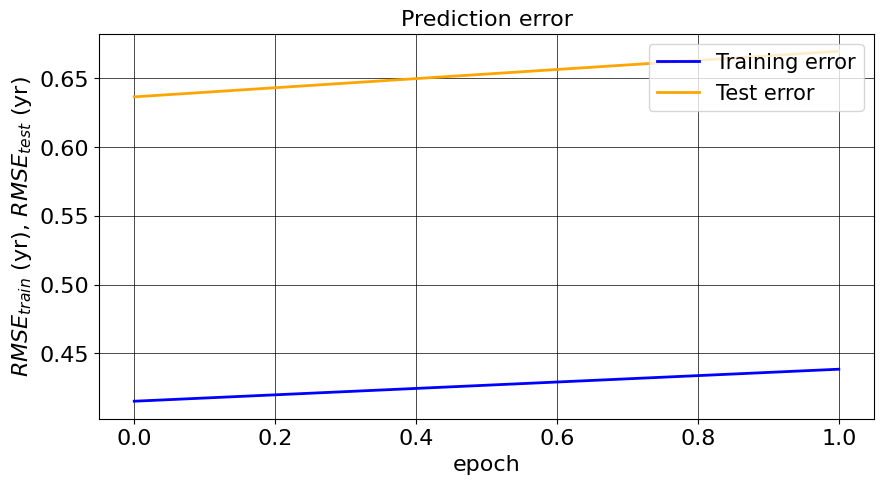

In [17]:
## initialization of the plot
plt.grid(color='black', axis='y', linestyle='-', linewidth=0.5)    
plt.grid(color='black', axis='x', linestyle='-', linewidth=0.5)   
plt.grid(which='minor',color='grey', axis='x', linestyle=':', linewidth=0.5)     
plt.grid(which='minor',color='grey', axis='y', linestyle=':', linewidth=0.5)    
plt.xticks(fontsize=16); plt.yticks(fontsize=16)   
plt.xlabel('epoch',fontsize=16 )
plt.ylabel(r'$RMSE_{train}$ (yr), $RMSE_{test}$ (yr)', size = 16)
## plotting the data
plt.plot(epoch, MSEtrain**0.5, color = "blue", linewidth = 2., label = "Training error")
plt.plot(epoch, MSEtest**0.5, color = "orange", linewidth = 2., label = "Test error")
plt.title("Prediction error", fontsize = 16)
plt.gcf().set_size_inches(10, 5)
plt.legend(loc="upper right", prop={'size': 15})
plt.savefig("fig01.png", dpi = 300,  bbox_inches='tight')
plt.show()

<strong>Task 12:</strong> Complete the code to compute the outputs on the test dataset using the optimized parameters.

x shape: (8, 1253)
NpL: [6, 1]
Nfx: 8
Wts: 2
n vaut: 1253
NL vaut: 2
WL shape: (6, 8)
yLm1 shape: (8, 1253)
bL shape: (1, 6)
zL shape: (6, 1253)
bL shape: (1, 6)
n 1253
WL shape: (1, 6)
yLm1 shape: (6, 1253)
bL shape: (1, 1)
zL shape: (1, 1253)
bL shape: (1, 1)
n 1253


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

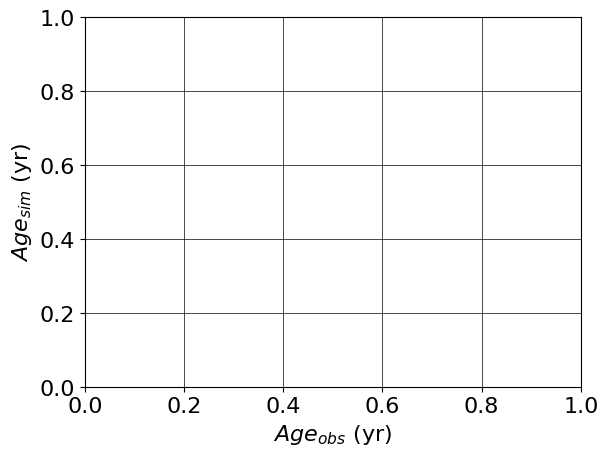

In [18]:
## Showing the results for the test dataset
x_in = xtest_scl.T
yout, zout = ANN(x = x_in, NpL = NpL, Nfx = Nfx, Wts = Wts, bias = bias, ActivFun = ActivFun)
ytestsim = yout
Error_test = np.dot((ytest - ytestsim[0]).T,(ytest - ytestsim[0]))/ntest
## Making a scatter plot
## initialization of the plot
plt.grid(color='black', axis='y', linestyle='-', linewidth=0.5)    
plt.grid(color='black', axis='x', linestyle='-', linewidth=0.5)   
plt.grid(which='minor',color='grey', axis='x', linestyle=':', linewidth=0.5)     
plt.grid(which='minor',color='grey', axis='y', linestyle=':', linewidth=0.5)    
plt.xticks(fontsize=16); plt.yticks(fontsize=16)   
plt.xlabel(r'$Age_{obs}$ (yr)',fontsize=16 )
plt.ylabel(r'$Age_{sim}$ (yr)',fontsize=16 )
## plotting the data
plt.scatter(ytest, ytestsim, color = "red", marker = "o")
plt.plot([0., 30.], [0., 30.], color='k', linestyle='-', linewidth=2)
plt.gcf().set_size_inches(6, 6)
plt.savefig("fig02.png", dpi = 300,  bbox_inches='tight')
plt.show()

## <strong>Part 3: Make your life easier with Keras</strong>

In this part, an implementation of a DNN using functions from Keras is shown.

### Step 1: Build the ANN architecture using Keras

<strong>Task 13:</strong> Modify the following function to implement the same ANN as the one implemented in Part 2.

In [22]:
def ANN_keras(shape):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(3, activation='logistic', name='HiddenLayer01'))
  model.add(keras.layers.Dense(1, activation='logistic', name='HiddenLayer02'))
  model.add(keras.layers.Dense(1, name='Output'))
  
  model.compile(optimizer = 'adam',
                loss      = 'mse',
                metrics   = ['mae', 'mse'] )
  return model

The following lines help create and instantiate an ANN using the function ```ANN_keras```.

<strong>Task 14:</strong> Use ```Nfx``` to create a "copy" of the ANN defined using ```ANN_keras```.

In [23]:
model= ANN_keras( (Nfx,) )
model.summary()

ValueError: Unknown activation function: 'logistic'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

### Step 2: Train and evaluate the model

Now, the model is ready for training. The following function launches the training of the ANN network.

In [ ]:
history = model.fit(x train,
                    y train,
                    epochs          = 50,
                    batch_size      = length of training dataset,
                    validation_data = (x test, y test))

The test scores are computed using the optimized parameter set on the test dataset.

In [ ]:
score = model.evaluate(xtest_scl, ytest, verbose=0)

print('test / loss      : {:5.4f}'.format(score[0]))
print('test / mae       : {:5.4f}'.format(score[1]))
print('test / mse       : {:5.4f}'.format(score[2]))

We can make a prediction with the Keras-built ANN and compare it with that from your own ANN.

In [ ]:
mydata = [ 1, 0.3, 0.1, 0.2, 0.2, 0.5, 0.7, -1. ]
mydata = np.array(mydata).reshape(1,8)
print(mydata.shape)
predictions = model.predict(mydata)
print("predicted age using Keras-built network: ", round(predictions[0,0],2), "yr")
yout, zout = ANN(x = mydata.T, NpL = NpL, Nfx = Nfx, Wts = Wts, bias = bias, ActivFun = ActivFun)
print("predicted age using your neural network: ", round(yout[NL-1][0,0], 2), "yr")

Finally, we can use parameters estimated by Keras and your neural network to test whether you get the same estimates.

In [ ]:
param_keras = model.get_weights()
len_par = len(param_keras)
wts_keras = [param_keras[i].T for i in np.arange(0, len_par, 2)]
bias_keras = [param_keras[i].reshape(param_keras[i].shape[0], 1) for i in np.arange(1, len_par, 2)]
ActivFun_Keras = ['relu', 'relu', 'relu', 'linear']
NpL_Keras = [16,32,16,1]
Nfx = 8
yout_k, zout_k = ANN(x = mydata.T, NpL = NpL_Keras, Nfx = Nfx, Wts = wts_keras, bias = bias_keras, ActivFun = ActivFun_Keras)
print("predicted age using Keras-built network: ", round(predictions[0,0],2), "yr")
print("predicted age using your neural network and Keras-estimated parameters: ", round(yout_k[len(NpL_Keras)-1][0,0], 2), "yr")